In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
#path = "D:/"
trainSamples = 75000
path = "/scratch/pbanerj6/sml-dataset/"
n_iter = 1000 
#n_trainSamples = [100,250,500,750,1000,1250,1500]
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train_cls = load_cls(path+"X_train_cls.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_cls.p")

y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [5]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.calibration import CalibratedClassifierCV

In [6]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'C': [0.001, 0.01, 0.1, 1,10],
    'tol': [0.001,0.0001],
    'validation_fraction': [0.1,0.2,0.05]
 }

In [7]:
lr_clf = GridSearchCV(PassiveAggressiveClassifier(loss='log', fit_intercept=True, max_iter= n_iter, n_jobs=-1), 
                      parameters,n_jobs=-1, verbose=4, iid=True,cv=5)

In [8]:
model = lr_clf.fit(X_train_cls, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


In [9]:
model.best_score_

0.6604266666666667

In [10]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'tol': 0.0001, 'C': 0.001, 'validation_fraction': 0.1}
C: 0.001
tol: 0.0001
validation_fraction: 0.1


In [11]:
pickle.dump(model,open("PassiveAggress_cls_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [12]:
X_test_cls = load_cls(path+"X_test_cls.p")
y_test = load_cls(path+"y_test.p")

In [13]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = CalibratedClassifierCV(PassiveAggressiveClassifier(loss='log', fit_intercept=True, max_iter= n_iter, n_jobs=-1,C=model.best_params_['C'],
                                           validation_fraction=model.best_params_['validation_fraction'],
                                                                   tol=model.best_params_['tol']))

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    bestModel.fit(X_train_cls[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_val = bestModel.predict(X_val_cls)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    preds_test = bestModel.predict(X_test_cls)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_cls)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
Train Time:0.06 sec


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Validation Accuracy: 51.95%
Validation Time:0.27 sec
Test Accuracy: 52.47%
Test Time:0.10 sec
(0.462100000000002, 0.21933333333333332, 0.5986666666666667)
MRR: 0.462100000000002
MRR Time:0.73 sec
SampleSize: 500
Train Time:0.16 sec
Validation Accuracy: 53.41%
Validation Time:0.04 sec


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Test Accuracy: 53.91%
Test Time:0.04 sec
(0.47274814814814947, 0.232, 0.604)
MRR: 0.47274814814814947
MRR Time:0.52 sec
SampleSize: 1000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Train Time:0.33 sec
Validation Accuracy: 56.57%
Validation Time:0.09 sec
Test Accuracy: 56.43%
Test Time:0.10 sec
(0.4971333333333346, 0.256, 0.644)
MRR: 0.4971333333333346
MRR Time:1.33 sec
SampleSize: 10000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Train Time:2.37 sec
Validation Accuracy: 61.03%
Validation Time:0.08 sec
Test Accuracy: 60.91%
Test Time:0.08 sec
(0.5539111111111131, 0.31666666666666665, 0.7306666666666667)
MRR: 0.5539111111111131
MRR Time:0.59 sec
SampleSize: 20000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Train Time:3.93 sec
Validation Accuracy: 62.33%
Validation Time:0.08 sec
Test Accuracy: 62.53%
Test Time:0.23 sec
(0.5813111111111128, 0.3566666666666667, 0.754)
MRR: 0.5813111111111128
MRR Time:0.61 sec
SampleSize: 50000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Train Time:6.48 sec
Validation Accuracy: 63.48%
Validation Time:0.06 sec
Test Accuracy: 63.76%
Test Time:0.05 sec
(0.5912777777777801, 0.37, 0.7693333333333333)
MRR: 0.5912777777777801
MRR Time:0.52 sec
SampleSize: 75000


/home/psukhapa/.conda/envs/sukha/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Train Time:7.66 sec
Validation Accuracy: 63.93%
Validation Time:0.04 sec
Test Accuracy: 64.25%
Test Time:0.07 sec
(0.5971000000000024, 0.37133333333333335, 0.7813333333333333)
MRR: 0.5971000000000024
MRR Time:0.52 sec
[0.5195, 0.5341, 0.5657, 0.6103, 0.6233, 0.6348, 0.6393]
[0.5247, 0.5391, 0.5643, 0.6091, 0.6253, 0.6376, 0.6425]
[0.462100000000002, 0.47274814814814947, 0.4971333333333346, 0.5539111111111131, 0.5813111111111128, 0.5912777777777801, 0.5971000000000024]
[0.21933333333333332, 0.232, 0.256, 0.31666666666666665, 0.3566666666666667, 0.37, 0.37133333333333335]
[0.5986666666666667, 0.604, 0.644, 0.7306666666666667, 0.754, 0.7693333333333333, 0.7813333333333333]


In [16]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Passive_Aggress_Accuracy_cls.png")
    plt.show()

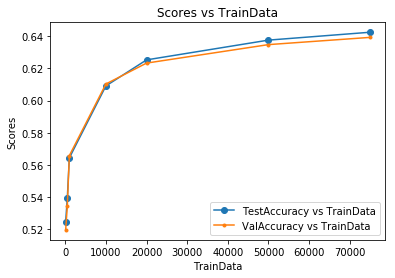

In [17]:
accuracyVisualization()

In [18]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Passive_Aggress_Mrr_cls.png")
    plt.show()

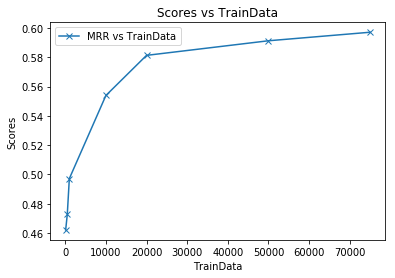

In [19]:
mrrVisualization()

In [20]:
#Precision @1 and Precision @2 Visualizations
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Passive_Aggress_Precision_cls.png")
    plt.show()

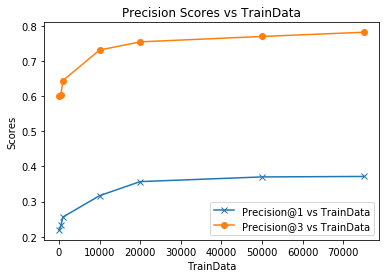

In [21]:
precisionVisualization()